In [0]:
%tensorflow_version 1.x

# HMM

* Markov Model: 현재 일어날 확률이 바로 이전의 확률에만 영향을 받는 확률 모델
* Hidden Markov Model: Markov Model + "관찰할 상대가 있음"

## Example

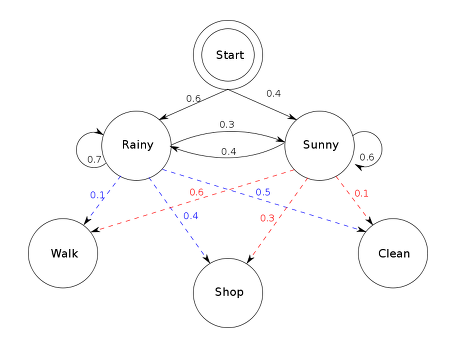

1. hidden state: Rainy, Sunny => 비나 맑음이라는 두 가지 상태는 알 수 있지만, 현재 날씨에 대한 생태는 전혀 알 수 없음

2. initial state 확률을 정의함. 여기서는 Rainy: 0.6, Sunny: 0.4로 정의되어 있음  
  이 지역은 대체적으로 비가 더 많이 왔음을 통계적으로 확인시켜줌

3. transition probability(전이 확률):  
   * 어제 rainy->오늘 sunny: 0.3
   * 어제 rainy->오늘 rainy: 0.7
   * 어제 sunny->오늘 rainy: 0.4
   * 어제 sunny->오늘 sunny: 0.6

4. emission_probability: 각각의 상태(rainy, sunny)는 각각이 방출할 수 있는 관측 결과를 나타낼 수 있음  
   여기에는 총 3개의 값이 있음: walk, shop, clean
   * rainy + walk: 0.1
   * rainy + shop: 0.4
   * rainy + clean: 0.5
   * sunny + walk: 0.6
   * sunny + shop: 0.3
   * sunny + clean: 0.1


<br><br>

이렇게 3가지의 확률 변수 값이 존재한다면, 어떤 결과가 예측되었을 때의 확률을 찾아낼 수 있음.

그렇다면,  
walk -> shop -> shop -> clean -> shop할 확률 값을 찾아보자.

In [0]:
import numpy as np
import tensorflow as tf

'''Define the HMM class'''
class HMM(object):
  def __init__(self, initial_prob, trans_prob, obs_prob):
    self.N = np.size(initial_prob)
    self.initial_prob = initial_prob
    self.trans_prob = trans_prob
    self.emission = tf.constant(obs_prob)

    assert self.initial_prob.shape == (self.N, 1)
    assert self.trans_prob.shape == (self.N, self.N)
    assert obs_prob.shape[0] == self.N

    self.obs_idx = tf.placeholder(tf.int32)
    self.fwd = tf.placeholder(tf.float64)

  def get_emission(self, obs_idx): 
    slice_location = [0, obs_idx]
    num_rows = tf.shape(self.emission)[0]
    slice_shape = [num_rows, 1]
    return tf.slice(self.emission, slice_location, slice_shape)

  def forward_init_op(self):
    obs_prob = self.get_emission(self.obs_idx)
    fwd = tf.multiply(self.initial_prob, obs_prob)
    return fwd

  def forward_op(self):
    transitions = tf.matmul(self.fwd, tf.transpose(self.get_emission(self.obs_idx)))
    weighted_transitions = transitions * self.trans_prob 
    fwd = tf.reduce_sum(weighted_transitions, 0) 
    return tf.reshape(fwd, tf.shape(self.fwd))







def forward_algorithm(sess, hmm, observations): 
  fwd = sess.run(hmm.forward_init_op(), feed_dict={hmm.obs_idx: observations[0]}) # observations[0]: walk
  for t in range(1, len(observations)): 
    fwd = sess.run(hmm.forward_op(), feed_dict={hmm.obs_idx: observations[t], hmm.fwd:fwd}) 
    prob = sess.run(tf.reduce_sum(fwd)) 
  return prob

In [4]:
''' Make settings '''
initial_prob = np.array([ [0.6], [0.4] ]) # rainy, sunny

trans_prob = np.array([ 
                       [0.7, 0.3], # rainy->rainy, rainy->sunny,
                       [0.4, 0.6]  # sunny->rainy, sunny->sunny
                       ])  
obs_prob = np.array([
                     [0.1, 0.4, 0.5], # rainy: walk, shop, clean
                     [0.6, 0.3, 0.1]  # sunny: walk, shop, clean
                    ])



''' Insert settings '''
hmm = HMM(initial_prob = initial_prob, trans_prob = trans_prob, obs_prob = obs_prob)



''' Make what we want to figure prob and print out that
    (walk->shop->shop->clean->shop)                     '''
observations = [0, 1, 1, 2, 1] # 0: walk / 1: shop / 2: clean

with tf.Session() as sess:
  prob = forward_algorithm(sess, hmm, observations)
  print('Probability of observing {} is {}'.format(observations, prob))

Probability of observing [0, 1, 1, 2, 1] is 0.004540300799999999
